In [71]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import add
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.applications.imagenet_utils import preprocess_input 
import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

- 데이터 확인

In [112]:
base_dir = "./Data3"

train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "val")

train_d1_dir = os.path.join(train_dir, "건강")
train_d2_dir = os.path.join(train_dir, "점무늬병")
train_d3_dir = os.path.join(train_dir, "흰가루병")

test_d1_dir = os.path.join(test_dir, "건강v")
test_d2_dir = os.path.join(test_dir, "점무늬병v")
test_d3_dir = os.path.join(test_dir, "흰가루병v")

In [113]:
print("훈련용 건강 데이터 개수 : ", len(os.listdir(train_d1_dir)))
print("훈련용 점무늬병 데이터 개수 : ", len(os.listdir(train_d2_dir)))
print("훈련용 흰가루병 데이터 개수 : ", len(os.listdir(train_d3_dir)))

print("검증용 건강 데이터 개수 : ", len(os.listdir(test_d1_dir)))
print("검증용 점무늬병 데이터 개수 : ", len(os.listdir(test_d2_dir)))
print("검증용 흰가루병 데이터 개수 : ", len(os.listdir(test_d3_dir)))

훈련용 건강 데이터 개수 :  900
훈련용 점무늬병 데이터 개수 :  900
훈련용 흰가루병 데이터 개수 :  900
검증용 건강 데이터 개수 :  140
검증용 점무늬병 데이터 개수 :  140
검증용 흰가루병 데이터 개수 :  140


- 모델 선언(resnet50/inceptionv3)

In [114]:
IMG_SIZE = (244, 244, 3)
inceptionv3 = InceptionV3(include_top=False, weights='imagenet', input_shape=IMG_SIZE) 

- 모델동결 및 미세조정

In [115]:
y = inceptionv3.output
y = GlobalAveragePooling2D()(y)
y = BatchNormalization()(y)
y = Dropout(0.5)(y)
y = Dense(1024, activation="relu")(y)
y = BatchNormalization()(y)
y = Dropout(0.5)(y)
y = Dense(512, activation="relu")(y)
predictions2 = Dense(3, activation="softmax")(y) # 식물 종수에 따라서 숫자 바꾸기
model1 = Model(inputs=inceptionv3.input, outputs=predictions2)

model1.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 244, 244, 3) 0                                            
__________________________________________________________________________________________________
conv2d_470 (Conv2D)             (None, 121, 121, 32) 864         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_488 (BatchN (None, 121, 121, 32) 96          conv2d_470[0][0]                 
__________________________________________________________________________________________________
activation_470 (Activation)     (None, 121, 121, 32) 0           batch_normalization_488[0][0]    
____________________________________________________________________________________________

In [116]:
for i, layer in enumerate(inceptionv3.layers):
    print(i,layer.name)

0 input_7
1 conv2d_470
2 batch_normalization_488
3 activation_470
4 conv2d_471
5 batch_normalization_489
6 activation_471
7 conv2d_472
8 batch_normalization_490
9 activation_472
10 max_pooling2d_20
11 conv2d_473
12 batch_normalization_491
13 activation_473
14 conv2d_474
15 batch_normalization_492
16 activation_474
17 max_pooling2d_21
18 conv2d_478
19 batch_normalization_496
20 activation_478
21 conv2d_476
22 conv2d_479
23 batch_normalization_494
24 batch_normalization_497
25 activation_476
26 activation_479
27 average_pooling2d_45
28 conv2d_475
29 conv2d_477
30 conv2d_480
31 conv2d_481
32 batch_normalization_493
33 batch_normalization_495
34 batch_normalization_498
35 batch_normalization_499
36 activation_475
37 activation_477
38 activation_480
39 activation_481
40 mixed0
41 conv2d_485
42 batch_normalization_503
43 activation_485
44 conv2d_483
45 conv2d_486
46 batch_normalization_501
47 batch_normalization_504
48 activation_483
49 activation_486
50 average_pooling2d_46
51 conv2d_482
52

In [117]:
for layer in inceptionv3.layers[:299]:
        layer.trainable = False

- 데이터 제너레이터(데이터 증식도 이용)

In [123]:
classes = 3
epochs = 16
#epochs = 500
targetx = 244
targety = 244

In [119]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 위노그라드 알고리즘 설정
os.environ['TF_ENABLE_WINOGRAD_NONFUSED'] = '1'

rootPath = './Data3'

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)


trainGen = train_datagen.flow_from_directory(
    os.path.join(rootPath, 'train'),
    target_size=(targetx, targety),
    subset='training',
    shuffle=True,
    class_mode='categorical'    
)

validationGen = val_datagen.flow_from_directory(
    os.path.join(rootPath, 'val'),
    target_size=(targetx, targety),
    shuffle=True,
    class_mode='categorical'
)

Found 2700 images belonging to 3 classes.
Found 420 images belonging to 3 classes.


- 컴파일, 학습 진행

In [120]:
model1.compile(optimizer='adam', 
               loss='categorical_crossentropy', 
               metrics=['acc'])

In [124]:
import os
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

SAVE_DIR = "./Model/"
#해당 폴더가 없다면 생성
if not os.path.exists(SAVE_DIR) :
    os.mkdir(SAVE_DIR)
    
modelpath = SAVE_DIR + "pima_{epoch:03d}_{acc:.3f}_{val_acc:.3f}.hdf5"


#ModelCheckpoint 파라미터 설정
# filepath : 저장할 파일 경로
# moniter : 베스트 모델의 평가 기준(val_acc)
# save_best_only : monitor 값이 나아진 경우에만 저장
mc = ModelCheckpoint(filepath = modelpath,
                     monitor = "val_acc",
                     save_best_only = True)

# monitor : 중단하는 기준값
# patience : 학습이 나아지지 않더라도 몇개는 더 두고보는 것
es = EarlyStopping(monitor="val_acc", patience=10)

In [125]:
history = model1.fit_generator(
    trainGen, 
    epochs=epochs,
    validation_data=validationGen,
    verbose=1,
    callbacks = [mc,es]        
)

Epoch 1/16
85/85 [==============================] - 83s 970ms/step - loss: 0.1105 - acc: 0.9722 - val_loss: 0.0077 - val_acc: 0.9976
Epoch 2/16
85/85 [==============================] - 84s 987ms/step - loss: 0.0964 - acc: 0.9781 - val_loss: 0.0084 - val_acc: 0.9976
Epoch 3/16
85/85 [==============================] - 86s 1s/step - loss: 0.0544 - acc: 0.9852 - val_loss: 0.0477 - val_acc: 0.9929
Epoch 4/16
85/85 [==============================] - 87s 1s/step - loss: 0.0585 - acc: 0.9885 - val_loss: 0.0068 - val_acc: 0.9952
Epoch 5/16
85/85 [==============================] - 85s 1s/step - loss: 0.0778 - acc: 0.9859 - val_loss: 0.0051 - val_acc: 0.9976
Epoch 6/16
85/85 [==============================] - 85s 1s/step - loss: 0.0571 - acc: 0.9881 - val_loss: 0.0184 - val_acc: 0.9929
Epoch 7/16
85/85 [==============================] - 84s 990ms/step - loss: 0.0307 - acc: 0.9930 - val_loss: 0.0118 - val_acc: 0.9976
Epoch 8/16
85/85 [==============================] - 84s 988ms/step - loss: 0.0408

- 결과확인

[[1.0000000e+00 2.2132888e-11 1.2119261e-08]]
New image prediction :  건강
accuracy : 1.0


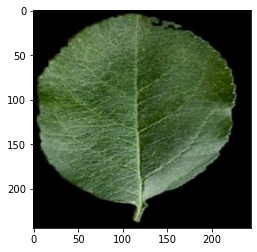

[[1.0000000e+00 1.2717261e-12 3.0278136e-09]]
New image prediction :  건강
accuracy : 1.0


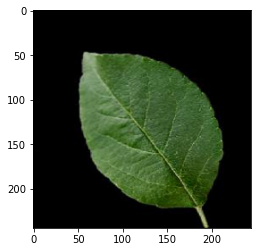

[[1.0000000e+00 9.3724203e-20 1.3119204e-15]]
New image prediction :  건강
accuracy : 1.0


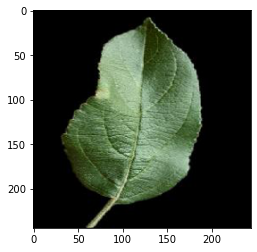

[[9.9999917e-01 2.3573756e-11 8.1578241e-07]]
New image prediction :  건강
accuracy : 0.9999991655349731


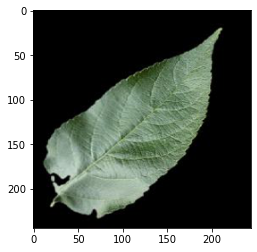

[[1.0000000e+00 2.2628463e-08 1.3085713e-08]]
New image prediction :  건강
accuracy : 1.0


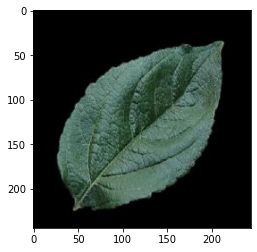

[[1.0454417e-11 1.0000000e+00 3.4624335e-08]]
New image prediction :  점무늬병
accuracy : 1.0454416846106263e-11


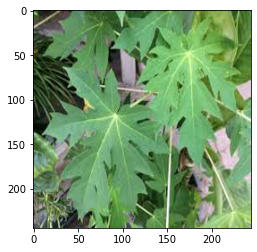

[[9.999511e-01 7.270948e-09 4.885564e-05]]
New image prediction :  건강
accuracy : 0.9999511241912842


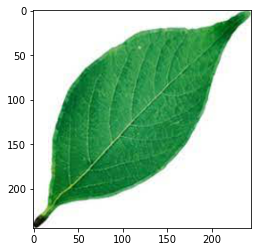

[[9.999958e-01 4.225041e-06 3.626304e-10]]
New image prediction :  건강
accuracy : 0.9999958276748657


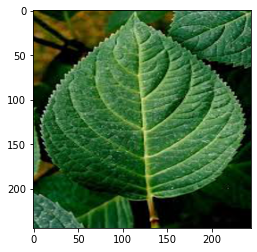

[[9.9996984e-01 2.0557443e-05 9.6378735e-06]]
New image prediction :  건강
accuracy : 0.9999698400497437


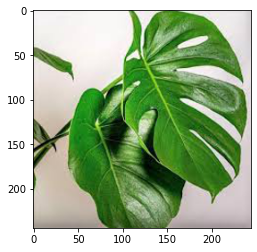

[[0.96698964 0.02482082 0.00818959]]
New image prediction :  건강
accuracy : 0.9669896364212036


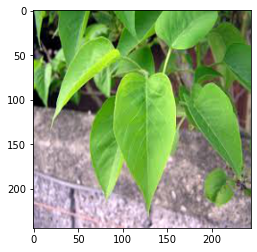

[[1.8565636e-14 1.0000000e+00 2.7752947e-09]]
New image prediction :  점무늬병
accuracy : 1.8565635750218863e-14


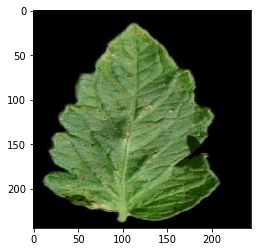

[[3.2233005e-16 1.0000000e+00 3.7300587e-14]]
New image prediction :  점무늬병
accuracy : 3.2233005009704946e-16


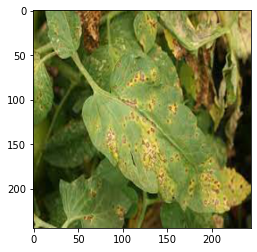

[[3.5376695e-18 1.0000000e+00 5.4110794e-10]]
New image prediction :  점무늬병
accuracy : 3.537669500154538e-18


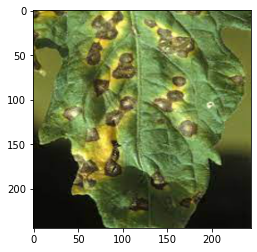

[[1.9559356e-21 1.0000000e+00 4.3303699e-14]]
New image prediction :  점무늬병
accuracy : 1.9559356052476905e-21


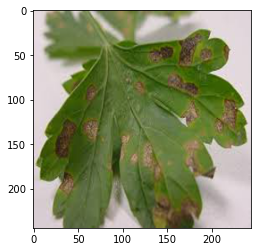

[[3.595287e-05 9.908539e-01 9.110184e-03]]
New image prediction :  점무늬병
accuracy : 3.595287125790492e-05


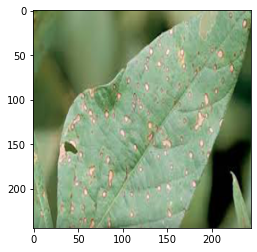

[[7.1118395e-16 1.0000000e+00 9.6358148e-09]]
New image prediction :  점무늬병
accuracy : 7.111839502890835e-16


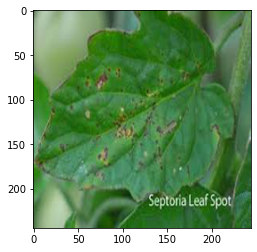

[[1.1572352e-16 1.0000000e+00 2.0032634e-13]]
New image prediction :  점무늬병
accuracy : 1.1572352060823423e-16


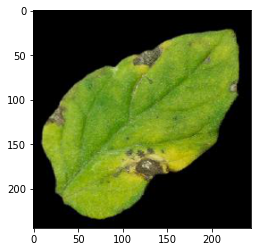

[[1.4810029e-22 1.0000000e+00 1.2817178e-19]]
New image prediction :  점무늬병
accuracy : 1.4810029196231135e-22


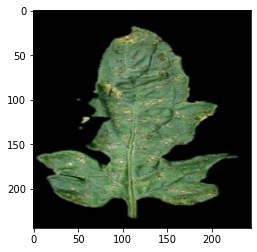

[[1.4718885e-24 1.0000000e+00 6.2841687e-19]]
New image prediction :  점무늬병
accuracy : 1.4718885272204121e-24


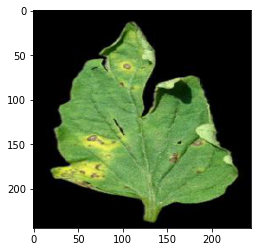

[[3.8462057e-24 1.0000000e+00 6.1757299e-19]]
New image prediction :  점무늬병
accuracy : 3.8462057282363e-24


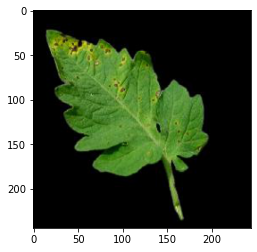

[[1.199010e-10 2.114603e-15 1.000000e+00]]
New image prediction :  흰가루병
accuracy : 1.1990100579062357e-10


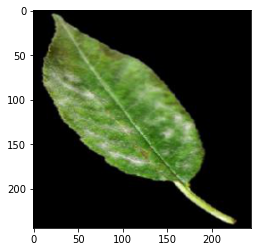

[[0.12760505 0.14476131 0.7276337 ]]
New image prediction :  흰가루병
accuracy : 0.12760505080223083


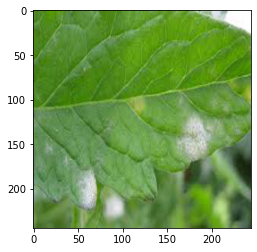

[[7.6546490e-07 2.2295238e-02 9.7770393e-01]]
New image prediction :  흰가루병
accuracy : 7.654649039068318e-07


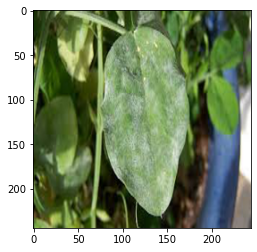

[[2.469171e-05 8.410261e-10 9.999753e-01]]
New image prediction :  흰가루병
accuracy : 2.4691709768376313e-05


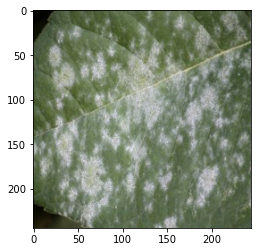

[[3.0774638e-18 7.3112052e-27 1.0000000e+00]]
New image prediction :  흰가루병
accuracy : 3.0774638440479043e-18


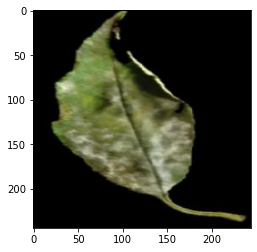

[[6.9087964e-17 1.7280441e-21 1.0000000e+00]]
New image prediction :  흰가루병
accuracy : 6.908796441011119e-17


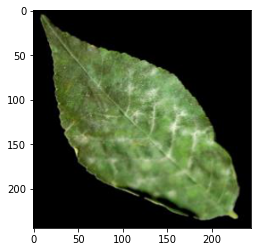

[[9.0546677e-17 3.7716483e-20 1.0000000e+00]]
New image prediction :  흰가루병
accuracy : 9.054667724351693e-17


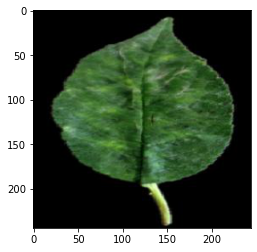

[[4.9360644e-24 2.4806655e-31 1.0000000e+00]]
New image prediction :  흰가루병
accuracy : 4.936064400453441e-24


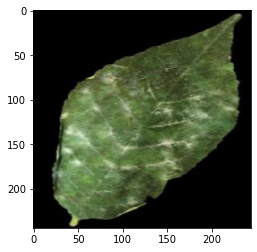

[[3.9659433e-08 9.4980270e-01 5.0197333e-02]]
New image prediction :  점무늬병
accuracy : 3.9659433070937666e-08


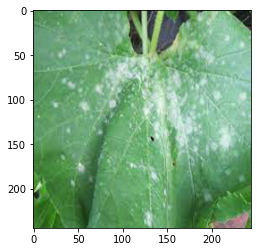

[[0.02029956 0.2599461  0.7197543 ]]
New image prediction :  흰가루병
accuracy : 0.020299557596445084


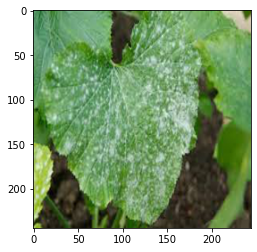

In [127]:
from tensorflow.keras.preprocessing import image
from PIL import Image
import matplotlib.pyplot as plt

test_dir = "./Data3/test/"

image_path = []
for i in os.listdir(test_dir):
    test_image_name = test_dir + i
    image_path.append(test_image_name)  

for image in image_path:
    img = Image.open(image)
    img = img.convert("RGB")
    img = img.resize((targetx,targety))    
    data = np.asarray(img)
    X = np.array(data)
    X = X.astype("float") / 256
    X = X.reshape(-1, targetx, targety,3)
    categories = ['건강','점무늬병','흰가루병'] # 카테고리 늘리기
    pred = model1.predict(X)
    print(pred)
    result = [np.argmax(value) for value in pred]   # 예측 값중 가장 높은 클래스 반환
    print('New image prediction : ',categories[result[0]])
    print("accuracy : {}".format(max(pred[0][0],pred[0][0])))
    plt.imshow(img)
    plt.show()

- ResNet50

In [58]:
resnet50 = ResNet50(include_top=False, weights='imagenet', input_shape=IMG_SIZE) 

In [59]:
resnet50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 244, 244, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 250, 250, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 122, 122, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 122, 122, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [60]:
for i, layer in enumerate(resnet50.layers):
    print(i, layer.name)

0 input_3
1 conv1_pad
2 conv1_conv
3 conv1_bn
4 conv1_relu
5 pool1_pad
6 pool1_pool
7 conv2_block1_1_conv
8 conv2_block1_1_bn
9 conv2_block1_1_relu
10 conv2_block1_2_conv
11 conv2_block1_2_bn
12 conv2_block1_2_relu
13 conv2_block1_0_conv
14 conv2_block1_3_conv
15 conv2_block1_0_bn
16 conv2_block1_3_bn
17 conv2_block1_add
18 conv2_block1_out
19 conv2_block2_1_conv
20 conv2_block2_1_bn
21 conv2_block2_1_relu
22 conv2_block2_2_conv
23 conv2_block2_2_bn
24 conv2_block2_2_relu
25 conv2_block2_3_conv
26 conv2_block2_3_bn
27 conv2_block2_add
28 conv2_block2_out
29 conv2_block3_1_conv
30 conv2_block3_1_bn
31 conv2_block3_1_relu
32 conv2_block3_2_conv
33 conv2_block3_2_bn
34 conv2_block3_2_relu
35 conv2_block3_3_conv
36 conv2_block3_3_bn
37 conv2_block3_add
38 conv2_block3_out
39 conv3_block1_1_conv
40 conv3_block1_1_bn
41 conv3_block1_1_relu
42 conv3_block1_2_conv
43 conv3_block1_2_bn
44 conv3_block1_2_relu
45 conv3_block1_0_conv
46 conv3_block1_3_conv
47 conv3_block1_0_bn
48 conv3_block1_3_bn

In [61]:
for layer in resnet50.layers[:171]:
        layer.trainable = False

In [62]:
x = resnet50.output

x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
predictions1 = Dense(3, activation="softmax")(x)
model2 = Model(inputs=resnet50.input, outputs=predictions1)

model2.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 244, 244, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 250, 250, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 122, 122, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 122, 122, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [64]:
classes = 3
epochs = 100
#epochs = 500
targetx = 244
targety = 244

In [67]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 위노그라드 알고리즘 설정
os.environ['TF_ENABLE_WINOGRAD_NONFUSED'] = '1'

rootPath = './Data3'

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)


trainGen = train_datagen.flow_from_directory(
    os.path.join(rootPath, 'train'),
    target_size=(targetx, targety),
    subset='training',
    shuffle=True,
    class_mode='categorical'    
)

validationGen = val_datagen.flow_from_directory(
    os.path.join(rootPath, 'val'),
    target_size=(targetx, targety),
    shuffle=True,
    class_mode='categorical'
)

Found 2970 images belonging to 3 classes.
Found 150 images belonging to 3 classes.


In [68]:
model2.compile(optimizer='adam', 
               loss='categorical_crossentropy', 
               metrics=['acc'])

In [69]:
import os
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

SAVE_DIR = "./Model/"
#해당 폴더가 없다면 생성
if not os.path.exists(SAVE_DIR) :
    os.mkdir(SAVE_DIR)
    
modelpath = SAVE_DIR + "pima_{epoch:03d}_{acc:.3f}_{val_acc:.3f}.hdf5"


#ModelCheckpoint 파라미터 설정
# filepath : 저장할 파일 경로
# moniter : 베스트 모델의 평가 기준(val_acc)
# save_best_only : monitor 값이 나아진 경우에만 저장
mc = ModelCheckpoint(filepath = modelpath,
                     monitor = "val_acc",
                     save_best_only = True)

# monitor : 중단하는 기준값
# patience : 학습이 나아지지 않더라도 몇개는 더 두고보는 것
es = EarlyStopping(monitor="val_acc", patience=10)

In [70]:
epochs = 100

history = model2.fit_generator(
    trainGen, 
    epochs=epochs,
    validation_data=validationGen,
    verbose=1,
    callbacks = [mc,es]        
)

Epoch 1/100
93/93 [==============================] - 218s 2s/step - loss: 1.3911 - acc: 0.5660 - val_loss: 1.2949 - val_acc: 0.3867
Epoch 2/100
93/93 [==============================] - 214s 2s/step - loss: 0.9623 - acc: 0.6911 - val_loss: 1.3912 - val_acc: 0.4400
Epoch 3/100
93/93 [==============================] - 210s 2s/step - loss: 0.6712 - acc: 0.7617 - val_loss: 2.3531 - val_acc: 0.5333
Epoch 4/100
93/93 [==============================] - 202s 2s/step - loss: 0.6450 - acc: 0.7680 - val_loss: 1.5851 - val_acc: 0.3600
Epoch 5/100
93/93 [==============================] - 202s 2s/step - loss: 0.5607 - acc: 0.7739 - val_loss: 0.9381 - val_acc: 0.6600
Epoch 6/100
93/93 [==============================] - 205s 2s/step - loss: 0.5322 - acc: 0.7924 - val_loss: 0.8693 - val_acc: 0.6400
Epoch 7/100
93/93 [==============================] - 202s 2s/step - loss: 0.4866 - acc: 0.8079 - val_loss: 0.8344 - val_acc: 0.6133
Epoch 8/100
93/93 [==============================] - 204s 2s/step - loss: 0.

KeyboardInterrupt: 

In [ ]:
# result = model2.predict(arr.reshape(1, 150, 150, 3))
# print(result)

In [ ]:
from tensorflow.keras.preprocessing import image
from PIL import Image
import matplotlib.pyplot as plt

test_dir = "./Data3/test/"

image_path = []
for i in os.listdir(test_dir):
    test_image_name = test_dir + i
    image_path.append(test_image_name)  

for image in image_path:
    img = Image.open(image)
    img = img.convert("RGB")
    img = img.resize((targetx,targety))    
    data = np.asarray(img)
    X = np.array(data)
    X = X.astype("float") / 256
    X = X.reshape(-1, targetx, targety,3)
    categories = ['건강','잎응애','점무늬병','흰가루병'] # 카테고리 늘리기
    pred = model1.predict(X)
    print(pred) # 결과값(%) 뽑기위함
    result = [np.argmax(value) for value in pred]   # 예측 값중 가장 높은 클래스 반환
    print('New image prediction : ',categories[result[0]])
    print("accuracy : {}".format(max(pred[0][0],pred[0][0])))
    plt.imshow(img)
    plt.show()